## Kernel to load: vax_inc_arcgis 

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import pycountry
from descartes import PolygonPatch
import pickle
import os
import arcpy
from arcgis.features import GeoAccessor
from textwrap import wrap
import warnings
warnings.simplefilter("ignore", UserWarning)

In [2]:
notebook_dir = os.path.dirname(os.getcwd())
source_data_path=os.path.join(notebook_dir, "Common Source Data")

In [3]:
df_pop_cattle=pd.read_csv(os.path.join(source_data_path, 'cattle','cattle_pop_2024.csv'))
df_pop_cattle=df_pop_cattle[df_pop_cattle['Year'].isin([2020])]
df_pop_cattle2=pd.read_csv(os.path.join(source_data_path, 'cattle','cattle_pop_2024.csv')).sort_values('Year').drop_duplicates('Area Code (M49)',keep='last').loc[:,['Area Code (M49)','Value']]
df_pop_cattle=df_pop_cattle.merge(df_pop_cattle2, how='left',left_on='Area Code (M49)',right_on='Area Code (M49)')
df_pop_cattle.rename(columns={'Value_x':'2020 pop','Value_y':'latest pop'},inplace=True)
df_pop_cattle['scale']=df_pop_cattle['latest pop']/df_pop_cattle['2020 pop']



df_pop_poultry=pd.read_csv(os.path.join(source_data_path, 'poultry','poultry_pop_2024.csv'))
df_pop_poultry = (
    df_pop_poultry.groupby(['Area Code (M49)', 'Year Code'], as_index=False)
    .agg({
        'Domain Code': 'first',
        'Domain': 'first',
        'Area Code (M49)': 'first',
        'Area': 'first',
        'Element Code': 'first',
        'Element': 'first',
        'Item Code (CPC)': 'first',
        'Year Code': 'first',
        'Year': 'first',
        'Unit': 'first',
        'Value': 'sum',  
        'Flag': 'first',
        'Flag Description': 'first',
        'Note': 'first'
    })
)
df_pop_poultry['Item'] = 'Poultry'
df_pop_poultry=df_pop_poultry[df_pop_poultry['Year'].isin([2020])]
df_pop_poultry2=pd.read_csv(os.path.join(source_data_path, 'poultry','poultry_pop_2024.csv')).sort_values('Year')
df_pop_poultry2 = (
    df_pop_poultry2.groupby(['Area Code (M49)', 'Year Code'], as_index=False)
    .agg({
        'Domain Code': 'first',
        'Domain': 'first',
        'Area Code (M49)': 'first',
        'Area': 'first',
        'Element Code': 'first',
        'Element': 'first',
        'Item Code (CPC)': 'first',
        'Year Code': 'first',
        'Year': 'first',
        'Unit': 'first',
        'Value': 'sum',  
        'Flag': 'first',
        'Flag Description': 'first',
        'Note': 'first'
    })
)
df_pop_poultry2=df_pop_poultry2.drop_duplicates('Area Code (M49)',keep='last').loc[:,['Area Code (M49)','Value']]
df_pop_poultry=df_pop_poultry.merge(df_pop_poultry2, how='left',left_on='Area Code (M49)',right_on='Area Code (M49)')
df_pop_poultry.rename(columns={'Value_x':'2020 pop','Value_y':'latest pop'},inplace=True)
df_pop_poultry['scale']=df_pop_poultry['latest pop']/df_pop_poultry['2020 pop']

df_pop_swine=pd.read_csv(os.path.join(source_data_path, 'swine','swine_pop_2024.csv'))
df_pop_swine=df_pop_swine[df_pop_swine['Year'].isin([2020])]
df_pop_swine2=pd.read_csv(os.path.join(source_data_path, 'swine','swine_pop_2024.csv')).sort_values('Year').drop_duplicates('Area Code (M49)',keep='last').loc[:,['Area Code (M49)','Value']]
df_pop_swine=df_pop_swine.merge(df_pop_swine2, how='left',left_on='Area Code (M49)',right_on='Area Code (M49)')
df_pop_swine.rename(columns={'Value_x':'2020 pop','Value_y':'latest pop'},inplace=True)
df_pop_swine['scale']=df_pop_swine['latest pop']/df_pop_swine['2020 pop']


#Taking care of edge cases (for example, if older population size was estimted at '0', or some other issue, despite having vaccination data, and gridded livestock data for the animal (technical issue with one of the data sources, I believe only 1 instance, with Iran Swine, where past and present is listed at 0 ))
df_pop_swine['scale'] = df_pop_swine['scale'].replace(np.nan, 1)
df_pop_poultry['scale'] = df_pop_poultry['scale'].replace(np.nan, 1)
df_pop_cattle['scale'] = df_pop_cattle['scale'].replace(np.nan, 1)



In [4]:
pop_countries_cattle = df_pop_cattle['Area']
pop_countries_poultry = df_pop_poultry['Area']
pop_countries_swine = df_pop_swine['Area']

countries = {}
for country in pycountry.countries:
    countries[country.name] = country.alpha_3
    countries['USA']='USA'
    countries['UK']='GBR'
    countries['Taiwan']='TWN'
    countries['South Korea']='KOR'
    countries['Czech Republic']='CZE'
    countries['Brunei']='BRN'
    countries['Russia']='RUS'
    countries['IrAAan']='IRN'
    countries['United States of America']='USA'
    countries['Venezuela']='VEN'
    countries['China (Hong Kong SAR)']='HKG'
    countries["Cote d'Ivoire"]='CIV'
    countries['DR Congo']='COD'
    countries['Guinea Bissau']='GNB'
    countries['Lao PDR']='LAO'
    countries['Micronesia (Federated States of)']='FSM'
    countries['North Korea']='PRK'
    countries['Occupied Palestinian Territory']='PSE'
    countries['Swaziland']='SWZ'
    countries['Tanzania']='TZA'
    countries['Bolivia']='BOL'
    countries['Macedonia (TFYR)']='MKD'
    countries['Moldova']='MDA'
    countries['Bolivia (Plurinational State of)']='BOL'
    countries['China, Hong Kong SAR']='HKG'
    countries['China, Taiwan Province of']='TWN'
    countries['China, mainland']='CHN'
    countries['Czechoslovakia']='CSK'
    countries["Democratic People's Republic of Korea"]='PRK'
    countries['Democratic Republic of the Congo']='COD'
    countries['French Guyana']='GUF'
    countries['Micronesia']='FSM'
    countries['Palestine']='PSE'
    countries['Polynesia']='PYF'
    countries['Republic of Korea']='KOR'
    countries['Serbia and Montenegro']='SCG'
    countries['Sudan (former)']='SDN'
    countries['Türkiye']='TUR'
    countries['USSR']='SUN'
    countries['Iran (Islamic Republic of)']='IRN'
    countries['Republic of Moldova']='MDA'
    countries['United Kingdom of Great Britain and Northern Ireland']='GBR'
    countries['United Republic of Tanzania']='TZA'
    countries['Venezuela (Bolivarian Republic of)']='VEN'
    countries['Yugoslav SFR']='YUG'
    countries['Ethiopia PDR']='ETH'
    countries['Central African (Rep.)']='CAF'
    countries["China (People's Rep. of)"]='CHN'
    countries['Chinese Taipei']='TWN'
    countries['Congo (Dem. Rep. of the)']='COD'
    countries['Congo (Rep. of the)']='COG'
    countries["Cote D'Ivoire"]='CIV'
    countries['Dominican (Rep.)']='DOM'
    countries["Korea (Dem People's Rep. of)"]='PRK'
    countries['Korea (Rep. of)']='KOR'
    countries['Laos']='LAO'
    countries['South Sudan (Rep. of)']='SSD'
    countries['Syria']='SYR'
    countries['St. Vincent and the Grenadines']='VCT'
    countries['Vietnam']='VNM'
    countries['Reunion']='REU'
    countries['Guadaloupe']='GLP'
    countries['Netherlands (Kingdom of the)']='NLD'
    countries['China, Macao SAR']='MAC'
    countries['Türkiye (Rep. of)']='TUR'
    countries['Belgium-Luxembourg']="BLX"
    countries['Kosovo']='XKX'


codes_pop_cattle = [countries.get(country, 'Unknown code:'+country) for country in pop_countries_cattle]

iso3s_pop_cattle=[]

for i in pop_countries_cattle:
    try:
        iso3s_pop_cattle+=[countries[i]]
    except:
        iso3s_pop_cattle+=[None]
        
df_pop_cattle['ISO3']=iso3s_pop_cattle

codes_pop_poultry = [countries.get(country, 'Unknown code:'+country) for country in pop_countries_poultry]

iso3s_pop_poultry=[]

for i in pop_countries_poultry:
    try:
        iso3s_pop_poultry+=[countries[i]]
    except:
        iso3s_pop_poultry+=[None]
        
df_pop_poultry['ISO3']=iso3s_pop_poultry

codes_pop_swine = [countries.get(country, 'Unknown code:'+country) for country in pop_countries_swine]

iso3s_pop_swine=[]

for i in pop_countries_swine:
    try:
        iso3s_pop_swine+=[countries[i]]
    except:
        iso3s_pop_swine+=[None]
        
df_pop_swine['ISO3']=iso3s_pop_swine

print(np.unique(codes_pop_cattle+codes_pop_poultry+codes_pop_swine))  # prints ['AS', 'CA', 'FR']

['AFG' 'ALB' 'ARE' 'ARG' 'ARM' 'ATG' 'AUS' 'AUT' 'AZE' 'BDI' 'BEL' 'BEN'
 'BFA' 'BGD' 'BGR' 'BHR' 'BHS' 'BIH' 'BLR' 'BLX' 'BLZ' 'BOL' 'BRA' 'BRB'
 'BRN' 'BTN' 'BWA' 'CAF' 'CAN' 'CHE' 'CHL' 'CHN' 'CIV' 'CMR' 'COD' 'COG'
 'COK' 'COL' 'COM' 'CPV' 'CRI' 'CUB' 'CYP' 'CZE' 'DEU' 'DJI' 'DMA' 'DNK'
 'DOM' 'DZA' 'ECU' 'EGY' 'ERI' 'ESP' 'EST' 'ETH' 'FIN' 'FJI' 'FRA' 'FRO'
 'FSM' 'GAB' 'GBR' 'GEO' 'GHA' 'GIN' 'GLP' 'GMB' 'GNB' 'GNQ' 'GRC' 'GRD'
 'GTM' 'GUF' 'GUY' 'HKG' 'HND' 'HRV' 'HTI' 'HUN' 'IDN' 'IND' 'IRL' 'IRN'
 'IRQ' 'ISL' 'ISR' 'ITA' 'JAM' 'JOR' 'JPN' 'KAZ' 'KEN' 'KGZ' 'KHM' 'KIR'
 'KNA' 'KOR' 'KWT' 'LAO' 'LBN' 'LBR' 'LBY' 'LCA' 'LKA' 'LSO' 'LTU' 'LUX'
 'LVA' 'MAC' 'MAR' 'MDA' 'MDG' 'MEX' 'MKD' 'MLI' 'MLT' 'MMR' 'MNE' 'MNG'
 'MOZ' 'MRT' 'MTQ' 'MUS' 'MWI' 'MYS' 'NAM' 'NCL' 'NER' 'NGA' 'NIC' 'NIU'
 'NLD' 'NOR' 'NPL' 'NRU' 'NZL' 'OMN' 'PAK' 'PAN' 'PER' 'PHL' 'PNG' 'POL'
 'PRI' 'PRK' 'PRT' 'PRY' 'PSE' 'PYF' 'QAT' 'REU' 'ROU' 'RUS' 'RWA' 'SAU'
 'SDN' 'SEN' 'SGP' 'SLB' 'SLE' 'SLV' 'SOM' 'SRB' 'S

In [5]:
df_pop_cattle=df_pop_cattle[['scale','ISO3']]
df_pop_cattle['Animal']=['Cattle']*df_pop_cattle.shape[0]

df_pop_poultry=df_pop_poultry[['scale','ISO3']]
df_pop_poultry['Animal']=['Poultry']*df_pop_poultry.shape[0]


df_pop_swine=df_pop_swine[['scale','ISO3']]
df_pop_swine['Animal']=['Swine']*df_pop_swine.shape[0]


In [6]:
df_animals=pd.concat([df_pop_cattle,df_pop_poultry,df_pop_swine])
df_animals=df_animals.dropna(axis='rows')

In [7]:
SHAPEFILE = os.path.join(source_data_path,'World_Countries_Map/World_Countries__Generalized_.shp')

# Read shapefile using Geopandas
geo_df = gpd.read_file(SHAPEFILE)
# Rename columns.
geo_df=geo_df.loc[:,['COUNTRY', 'ISO', 'geometry']]
geo_df.head(3)

,COUNTRY,ISO,geometry
0,Afghanistan,AF,"POLYGON ((61.27655 35.60725, 61.29638 35.62854..."
1,Albania,AL,"POLYGON ((19.57083 41.68527, 19.58195 41.69569..."
2,Algeria,DZ,"POLYGON ((4.60335 36.88791, 4.63555 36.88638, ..."


<AxesSubplot:>

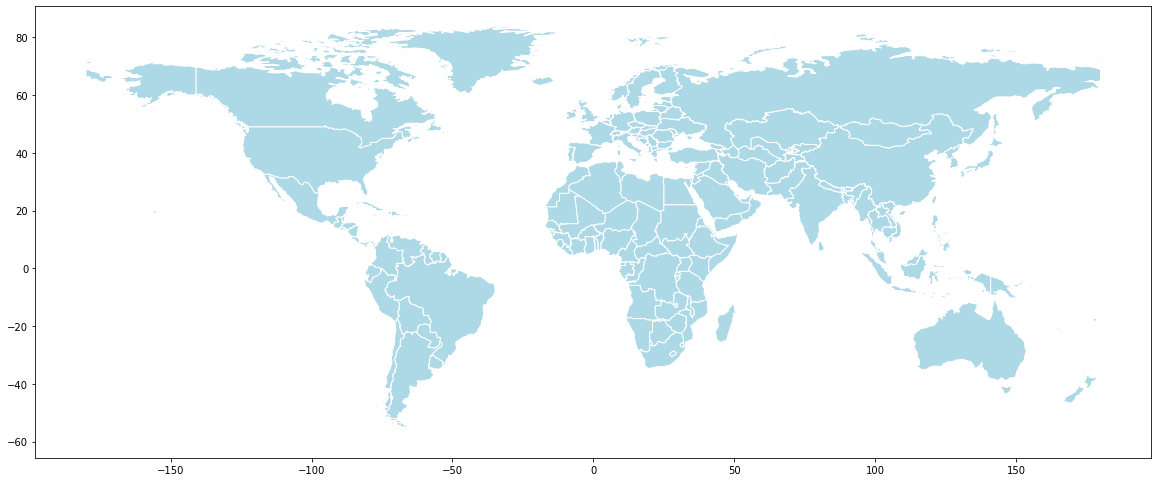

In [8]:
# Drop row for 'Antarctica'. It takes a lot of space in the map and is not of much use
geo_df = geo_df.drop(geo_df.loc[geo_df['COUNTRY'] == 'Antarctica'].index)
geo_df.reset_index(drop=True, inplace=True)

geo_df.plot(figsize=(20, 20), edgecolor='white', linewidth=1, color='lightblue')

In [9]:
pop_countries_geo = geo_df['ISO']

countries = {}
for country in pycountry.countries:
    countries[country.alpha_2] = country.alpha_3


codes_pop_geo = [countries.get(country, 'Unknown code:'+country) for country in pop_countries_geo]

iso3s_pop_geo=[]

for i in pop_countries_geo:
    try:
        iso3s_pop_geo+=[countries[i]]
    except:
        iso3s_pop_geo+=[None]
        
geo_df['ISO3']=iso3s_pop_geo


print(np.unique(codes_pop_geo))  # prints ['AS', 'CA', 'FR']

['ABW' 'AFG' 'AGO' 'AIA' 'ALB' 'AND' 'ARE' 'ARG' 'ARM' 'ASM' 'ATF' 'ATG'
 'AUS' 'AUT' 'AZE' 'BDI' 'BEL' 'BEN' 'BES' 'BFA' 'BGD' 'BGR' 'BHR' 'BHS'
 'BIH' 'BLM' 'BLR' 'BLZ' 'BMU' 'BOL' 'BRA' 'BRB' 'BRN' 'BTN' 'BVT' 'BWA'
 'CAF' 'CAN' 'CCK' 'CHE' 'CHL' 'CHN' 'CIV' 'CMR' 'COD' 'COG' 'COK' 'COL'
 'COM' 'CPV' 'CRI' 'CUB' 'CUW' 'CXR' 'CYM' 'CYP' 'CZE' 'DEU' 'DJI' 'DMA'
 'DNK' 'DOM' 'DZA' 'ECU' 'EGY' 'ERI' 'ESP' 'EST' 'ETH' 'FIN' 'FJI' 'FLK'
 'FRA' 'FRO' 'FSM' 'GAB' 'GBR' 'GEO' 'GGY' 'GHA' 'GIB' 'GIN' 'GLP' 'GMB'
 'GNB' 'GNQ' 'GRC' 'GRD' 'GRL' 'GTM' 'GUF' 'GUM' 'GUY' 'HMD' 'HND' 'HRV'
 'HTI' 'HUN' 'IDN' 'IMN' 'IND' 'IOT' 'IRL' 'IRN' 'IRQ' 'ISL' 'ISR' 'ITA'
 'JAM' 'JEY' 'JOR' 'JPN' 'KAZ' 'KEN' 'KGZ' 'KHM' 'KIR' 'KNA' 'KOR' 'KWT'
 'LAO' 'LBN' 'LBR' 'LBY' 'LCA' 'LIE' 'LKA' 'LSO' 'LTU' 'LUX' 'LVA' 'MAF'
 'MAR' 'MCO' 'MDA' 'MDG' 'MDV' 'MEX' 'MHL' 'MKD' 'MLI' 'MLT' 'MMR' 'MNE'
 'MNG' 'MNP' 'MOZ' 'MRT' 'MSR' 'MTQ' 'MUS' 'MWI' 'MYS' 'MYT' 'NAM' 'NCL'
 'NER' 'NFK' 'NGA' 'NIC' 'NIU' 'NLD' 'NOR' 'NPL' 'N

In [10]:
with open(os.path.join(source_data_path,'vaccines_sorted_by_use.pickle'),'rb') as handle:
    _,_,_,top_vaccines=pickle.load(handle)

In [11]:
iso3_to_country=dict()
for country in pycountry.countries:
    iso3_to_country[country.alpha_3] = country.name

for iso3 in geo_df['ISO3']:
    if iso3 not in iso3_to_country.keys():
        print(iso3)

In [12]:
arcpy.env.workspace=notebook_dir
arcpy.env.overwriteOutput = True

In [13]:
df_animals

,scale,ISO3,Animal
0,1.073959,AFG,Cattle
1,0.700209,ALB,Cattle
2,1.054953,ARE,Cattle
3,0.999592,ARG,Cattle
4,0.966574,ARM,Cattle
...,...,...,...
175,0.970769,VUT,Swine
176,1.198365,WSM,Swine
177,0.961014,ZAF,Swine
178,0.981786,ZMB,Swine


In [14]:
for animal in ['Poultry','Cattle','Swine']:
    
    # Set local variables (DENSITIES)
    
    if animal =='Poultry':
        inConstant =os.path.join(source_data_path,"chickens_dataverse","GLW4-2020.D-DA.CHK.tif")
    elif animal == 'Cattle':
        inConstant =os.path.join(source_data_path,"cattle_dataverse","GLW4-2020.D-DA.CTL.tif")
    else:
        inConstant =os.path.join(source_data_path,"swine_dataverse","GLW4-2020.D-DA.PGS.tif")
        
    if animal =='Poultry':
        inRaster =os.path.join(source_data_path,"chickens_dataverse","Area10km.tif")
        save_to=os.path.join(source_data_path,"chickens_dataverse","number_chickens.tif")
    elif animal == 'Cattle':
        inRaster =os.path.join(source_data_path,"cattle_dataverse","Area10km.tif")
        save_to=os.path.join(source_data_path,'cattle_dataverse','number_cattle.tif')
    else:
        inRaster =os.path.join(source_data_path,"swine_dataverse","Area10km.tif")
        save_to=os.path.join(source_data_path,'swine_dataverse','number_pigs.tif')

    
    
 # Execute Times
    outTimes = arcpy.sa.Times(inRaster, inConstant)
    outTimes.save(save_to)

In [15]:
countries_missing_data = dict()
# Set the range for the choropleth
animals=['Cattle','Poultry','Swine']

os.makedirs("ARCPY Maps", exist_ok=True)
os.makedirs("ARCPY Maps/2024 pop", exist_ok=True)

    
for animal in animals:
        
    df_plot=df_animals[(df_animals['Animal']==animal)]
    df_plot=df_plot.drop_duplicates(subset=['ISO3'], keep='last')
        
    merged_df = pd.merge(right=df_plot,left=geo_df, how='left', left_on='ISO3', right_on='ISO3')
    
    merged_df['scale']=[i if i==i else 1 for i in merged_df['scale']]
    
    merged_df['Animal']=[animal for i in merged_df['Animal']]
    
    df_copy = merged_df.to_crs('epsg:4326')
    merged_df['area'] = df_copy['geometry'].area / 10**6


    
    if not os.path.exists('ARCPY Maps/2024 pop/'+animal+'/'):
        os.makedirs('ARCPY Maps/2024 pop/'+animal+'/')
    
    
    to_feature_class=merged_df.copy()
    to_feature_class = to_feature_class[to_feature_class['scale'].notna()]
    
    
    to_feature_class.rename(columns={'Latest population recorded':'latest_pop','country_code':'count_code','Year latest population':'year_pop','High Resolution':'high_res','Vaccine Coverage':'vacc_cov'},inplace=True)
    
    GeoAccessor.from_geodataframe(to_feature_class, inplace=False, column_name='SHAPE').spatial.to_featureclass(location='ARCPY Maps/2024 pop/'+animal+'/feature_class.shp',sanitize_columns=False)
    
    arcpy.conversion.PolygonToRaster(in_features='ARCPY Maps/2024 pop/'+animal+'/feature_class.shp', value_field="scale",out_rasterdataset='ARCPY Maps/2024 pop/'+animal+'/scale',
                                     cell_assignment='CELL_CENTER',cellsize=0.08333333333333333)
    # Set local variables
    inRaster = 'ARCPY Maps/2024 pop/'+animal+'/scale'
    
    if animal =='Poultry':
        inConstant =os.path.join(source_data_path,'chickens_dataverse','number_chickens.tif')
    elif animal == 'Cattle':
        inConstant =os.path.join(source_data_path,"cattle_dataverse","number_cattle.tif")
    else:
        inConstant =os.path.join(source_data_path,"swine_dataverse","number_pigs.tif")
    # Execute Times
    outTimes = arcpy.sa.Times(inRaster, inConstant)
    outTimes.save('ARCPY Maps/2024 pop/'+animal+'/scaled_pop.tif')

    
    # Set local variables
    inRaster = 'ARCPY Maps/2024 pop/'+animal+'/scaled_pop.tif'
    
    if animal =='Poultry':
        inConstant =os.path.join(source_data_path,"chickens_dataverse","Area10km.tif")
    elif animal == 'Cattle':
        inConstant =os.path.join(source_data_path,"cattle_dataverse","Area10km.tif")
    else:
        inConstant =os.path.join(source_data_path,"swine_dataverse","Area10km.tif")
    
    # Execute Divide
    outDivide = arcpy.sa.Divide(inRaster, inConstant)
    outDivide.save('ARCPY Maps/2024 pop/'+animal+'/scaled_pop_density_(plot).tif')
    
    inRaster = 'ARCPY Maps/2024 pop/'+animal+'/scaled_pop_density_(plot).tif'
    inConstant =1
    
    # Execute Plus
    outPlus = arcpy.sa.Plus(inRaster, inConstant)
    outPlus.save('ARCPY Maps/2024 pop/'+animal+'/scaled_pop_density_plus_1.tif')
    
    
     # Set local variables
    inRaster = 'ARCPY Maps/2024 pop/'+animal+'/scaled_pop_density_plus_1.tif'
    
    # Execute Log10
    outLog10 = arcpy.sa.Log10(inRaster)
    
    # Save the output 
    outLog10.save('ARCPY Maps/2024 pop/'+animal+'/log_scaled_pop_density_plus_1_(plot).tif')